In [1]:
# import env
from keras.models import Model
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, Input, Activation, Reshape, Flatten, ZeroPadding2D
from keras.callbacks import TensorBoard
from keras.utils import to_categorical, plot_model
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.utils.vis_utils import model_to_dot
import numpy as np
import matplotlib.pyplot as plt
# from ImageUtils import ImageUtils
import pickle
import keras.backend as K
from keras import regularizers
from PIL import Image
import os
from ImageUtils import ImageUtils
from imageio import imwrite
from pandas import read_excel
import zipfile
from subprocess import check_output

D:\sf\conda\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
utils = ImageUtils()

In [14]:
'''常量'''
sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimages'
targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/rimagesResize'

root = ''


'''测试集'''
t_sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/test'
t_targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/testim'


'''验证集'''
v_sourceFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/validset'
v_targetFolder = 'D:/jupyter/car-management/recognitionalgorithm/dataset/validresizeim'

'''Train dataset'''
# trainXPath = 'dataset/dataset/dataset/licenseplateL_1_3.npy'
# trainYPath = 'dataset/dataset/dataset/label_1_3.npy'

trainXPath = 'D:/jupyter/car-management/recognitionalgorithm/dataset/licenseplateL_1_3.npy'
trainYPath = 'D:/jupyter/car-management/recognitionalgorithm/dataset/label_1_3.npy'

'''test dataset'''
# testXPath = 'dataset/dataset/dataset/t_licenseplateL_1_3.npy'
# testYPath = 'dataset/dataset/dataset/t_label_1_3.npy'
testXPath =  'D:/jupyter/car-management/recognitionalgorithm/dataset/t_licenseplateL_1_3.npy'
testYPath = 'D:/jupyter/car-management/recognitionalgorithm/dataset/t_label_1_3.npy'


'''valid dataset'''
validXPath = 'D:/jupyter/car-management/recognitionalgorithm/dataset/v_licenseplateL_1_3.npy'
validYPath = 'D:/jupyter/car-management/recognitionalgorithm/dataset/v_label_1_3.npy'


filename = 'D:/jupyter/car-management/recognitionalgorithm/dataset/字典.xlsx'

In [4]:
print(utils.readLabels(root, filename))

['冀', '辽', '皖', '苏', '鄂', '晋', '吉', '粤', '宁', '京', '豫', '黑', '鲁', '浙', '桂', '蒙', '闽', '川', '云', '湘', '新', '赣', '甘', '陕', '贵', '青', '藏', '琼', '沪', '渝', '津', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [5]:
print(utils.readLabels(root, filename))

['冀', '辽', '皖', '苏', '鄂', '晋', '吉', '粤', '宁', '京', '豫', '黑', '鲁', '浙', '桂', '蒙', '闽', '川', '云', '湘', '新', '赣', '甘', '陕', '贵', '青', '藏', '琼', '沪', '渝', '津', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [6]:
utils.resizeAndSaveImage(v_sourceFolder, v_targetFolder, shape = (400, 400))
'''resize image'''
# utils.resizeAndSaveImage(sourceFolder, targetFolder, shape = (400, 400))
# utils.resizeAndSaveImage(t_sourceFolder, t_targetFolder, shape = (400, 400))

'resize image'

In [10]:
'''处理数据'''
X = utils.readXData(targetFolder, shape = (400, 400, 3))
Y = utils.readYData(root, targetFolder, filename)
utils.save(root, trainXPath, trainYPath, X, Y)

t_X = utils.readXData(t_targetFolder, shape = (400, 400, 3))
t_Y = utils.readYData(root, t_targetFolder, filename)
utils.save(root, testXPath, testYPath, t_X, t_Y)

v_X = utils.readXData(v_targetFolder, shape = (400, 400, 3))
v_Y = utils.readYData(root, v_targetFolder, filename)
utils.save(root, validXPath, validYPath, v_X, v_Y)

In [11]:
'''load test dataset'''
X_test_orig, Y_test_orig = utils.load(root, testXPath, testYPath)
# X_test = X_test_orig / 255

'''load train dataset'''
X_train_orig, Y_train_orig = utils.load(root, trainXPath, trainYPath)
# X_train = X_train_orig / 255


'''load valid dataset'''
X_valid_orig, Y_valid_orig = utils.load(root, validXPath, validYPath)

Y_train = to_categorical(np.transpose(Y_train_orig), 66)

Y_label = []
for i in range(len(Y_train)):
    Y_label.append(Y_train[i])



In [ ]:
def inception_block(X, name, filters, strides):
    '''first layers'''
    f_skip_1, f_1_1, f_1_2, f_2_1, f_2_2, f_2_3 = filters 
    base_name = 'inception' + str(name)
    
    conv_1_1 = Conv2D(f_1_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    conv_1_2 = Conv2D(f_2_1, (1, 1), padding = 'same', strides = strides, name = base_name + '_c_1_2', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    pool_1_1 = MaxPooling2D((3, 3), strides = strides, padding = 'same', name = base_name + '_p_1_1')(X)
    
    conv_skip_1 = Conv2D(f_skip_1, (1, 1), strides = 2 * strides, padding = 'same', name = base_name + '_skip_1', activation = 'relu', kernel_initializer = 'truncated_normal')(X)
    
    conv_2_1 = Conv2D(f_2_1, (3, 3), padding = 'same', strides = strides, name = base_name + '_c_2_1', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_1)
    conv_2_2 = Conv2D(f_2_2, (5, 5), padding = 'same', strides = strides, name = base_name + '_c_2_2', activation = 'relu', kernel_initializer = 'truncated_normal')(conv_1_2)
    conv_2_3 = Conv2D(f_2_3, (1, 1), padding = 'same', strides =  strides, name = base_name + '_c_2_3', activation = 'relu', kernel_initializer = 'truncated_normal')(pool_1_1)
    
    # 合并
    inception = Concatenate(axis = -1, name = base_name + '_ct_1_1')([conv_skip_1, conv_2_1, conv_2_2, conv_2_3])
    
    bn = BatchNormalization(name = base_name + '_bn_1')(inception)
    
    return bn

In [ ]:
def identify_block(X, filters, name, strides):
    conv_name = 'identify_conv' + str(name)
    bn_name = 'identify_bn_name' + str(name)
    activation_name = 'identify_activation_name' + str(name)
    add_name = 'identify_add' + str(name)
    skip_name = 'identify_skip' + str(name)
    
    f_1_1, f_1_2, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (3, 3), strides = strides, padding = 'same', name = conv_name + '_1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_1_1 = BatchNormalization(name = bn_name + '_1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '_1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '_2_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '_2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '_2_1')(bn_2_1)
    
    '''skip unit'''
    skip_strides = 2 * strides
    if strides == 1:
        skip_strides = 1
        
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, padding = 'same', name = skip_name + '_1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    
    identify = Add(name = add_name + '_1_1')([activation_2_1, conv_skip_1_1])
    
    return identify

In [ ]:
'''build convlution block'''
def bottleneck_block(X, filters, name, strides):
    conv_name = 'bk_conv' + str(name)
    bn_name = 'bk_bn' + str(name)
    activation_name = 'bk_an' + str(name)
    add_name = 'bk_add' + str(name)
    skip_name = 'bk_sk' + str(name)
    
    f_1_1, f_1_2, f_1_3, skip_1_1 = filters
    
    '''first unit'''
    conv_1_1 = Conv2D(f_1_1, (1, 1), strides = strides, padding = 'same', name = conv_name + '1_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_1_1 = BatchNormalization(name = bn_name + '1_1')(conv_1_1)
    activation_1_1 = Activation('relu', name = activation_name + '1_1')(bn_1_1)
    
    '''second unit'''
    conv_2_1 = Conv2D(f_1_2, (3, 3), strides = strides, padding = 'same', name = conv_name + '2_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_1_1)
    bn_2_1 = BatchNormalization(name = bn_name + '2_1')(conv_2_1)
    activation_2_1 = Activation('relu', name = activation_name + '2_1')(bn_2_1)
    
    '''skip unit'''
    conv_3_1 = Conv2D(f_1_3, (1, 1), strides = strides, padding = 'same', name = conv_name + '3_1', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(activation_2_1)
    bn_3_1 = BatchNormalization(name = bn_name + '3_1')(conv_3_1)
    activation_3_1 = Activation('relu', name = activation_name + '3_1')(bn_3_1)
    
    '''skip unit'''
    skip_strides = int(pow(strides, 3))
    if strides == 1:
        skip_strides = 1
    conv_skip_1_1 = Conv2D(skip_1_1, (3, 3), strides = skip_strides, name = skip_name + 'c_1_1', padding = 'same', kernel_initializer = 'truncated_normal', kernel_regularizer = regularizers.l2(0.001))(X)
    bn_skip_1_1 = BatchNormalization(name = skip_name + '_1_1')(conv_skip_1_1)
    activation_skip_1_1 = Activation('relu', name = skip_name + 'an_1_1')(bn_skip_1_1)
    
    
    bottleneck = Add(name = add_name + '_1_1')([activation_3_1, activation_skip_1_1])
    
    return bottleneck

In [ ]:
'''build full network'''
def resnet_1_2(input_shape, full_conncet_nums = (512, 66), label = 7):
    '''inputs'''
    inputs = Input(shape = input_shape)
    
    
    '''inception'''
    inception = inception_block(inputs, 1, (32, 32, 32, 32, 32, 32), strides = 2)
    
    '''dropout 0.5'''
    d_inception = Dropout(0.25)(inception)
    
    '''128 filters, identify name: 1  256 filters, bottleneck name: 1'''
    bottleneck_block_1 = bottleneck_block(d_inception, filters = (128, 128, 128, 128), name = 1, strides = 2)
    identify_block_1 = identify_block(bottleneck_block_1, filters = (256, 256, 256), name = 1, strides = 1)
    
    
    '''max pooling'''
    mp2d = MaxPooling2D(pool_size = (2, 2))(identify_block_1)
    
    '''relu activation'''
    an_block_1 = Activation('relu', name = 'model_an_1')(mp2d)
    
    '''dropout'''
    d_bottleneck_block_1 = Dropout(0.25)(an_block_1)
    
    '''256 filters, identify name: 2  512 filters, bottleneck name: 2'''
    bottleneck_block_2 = bottleneck_block(d_bottleneck_block_1, filters = (512, 512, 512, 512), name = 2, strides = 1)
    identify_block_2 = identify_block(bottleneck_block_2, filters = (1024, 1024, 1024), name = 2, strides = 1)
    
    '''relu activation'''
    an_block_2 = Activation('relu', name = 'model_an_2')(identify_block_2)
    
    '''dropout'''
    d_bottleneck_block_2 = Dropout(0.25)(an_block_2)
    
    '''1024 filters, identify name: 2  2048 filters, bottleneck name: 2'''
#     bottleneck_block_3 = bottleneck_block(d_bottleneck_block_2, filters = (1024, 1024, 1024, 1024), name = 3, strides = 2)
#     identify_block_3 = identify_block(d_bottleneck_block_2, filters = (2048, 2048, 2048), name = 3, strides = 2)
    
    '''average pooling'''
    ap2d = AveragePooling2D(pool_size = (1, 1))(d_bottleneck_block_2)
    
    '''dropout 0.05'''
    d_bottleneck_block_3 = Dropout(0.5)(ap2d)
    
    
    '''flatten'''
    flatten = Flatten()(d_bottleneck_block_3)
    
    '''full connect params'''
    full_connect_num_1, full_connect_num_2 = full_conncet_nums
    
    '''full connect layer 1'''
    full_connect1 = Dense(full_connect_num_1, activation = 'relu', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.1))(flatten)
    
    '''store outputs'''
    outputs = []
    '''full conncet layer 2'''
    for i in range(label):
        end_full_connect = Dense(full_connect_num_2, activation = 'softmax', kernel_initializer = 'glorot_normal', kernel_regularizer = regularizers.l2(0.1))(full_connect1)
        outputs.append(end_full_connect)
    
#     concat = Concatenate(axis = 0, name = 'model_ct_1')(outputs)
    
    '''build model'''
    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
model = resnet_1_2(input_shape = (400, 400, 3))

In [ ]:
# model.summary()

In [ ]:
'''callback to record log'''
logdir = './logs'
tbcallback = TensorBoard(log_dir=logdir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [ ]:
'''compile model'''
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
'''train model'''
model.fit(X_train_orig, Y_label, batch_size = 32, epochs = 700, shuffle= True, callbacks = [tbcallback])

In [4]:
resnet_1_3_config = 'D:/jupyter/car-management/recognitionalgorithm/dataset/resnet3/inputsresnet_1_3_config.pickle'
resnet_1_3_weights = 'D:/jupyter/car-management/recognitionalgorithm/dataset/resnet3/resnet_1_3_config_weights.h5'
resnet_1_3_json = 'D:/jupyter/car-management/recognitionalgorithm/dataset/resnet3/inputsresnet_1_3.json'

In [ ]:
'''save model config'''
config = model.get_config()
with open(resnet_1_3_config, 'wb') as f:
    pickle.dump({'config': config}, f)

'''save weights'''
model.save_weights(resnet_1_3_weights)

In [5]:
'''build model weights'''
from keras.models import model_from_config
import json
with open(resnet_1_3_config, 'rb') as f:
    build_config =  pickle.load(f)
    build_config = build_config['config']
build_model = Model.from_config(build_config)
build_model.load_weights(resnet_1_3_weights)

[9, 41, 39, 39, 38, 34, 32]


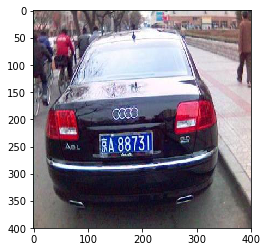

In [15]:
plt.imshow(X_test_orig[0])
print(utils.getlistargmax(build_model.predict(X_test_orig[0].reshape(1, 400, 400, 3))))

In [12]:
index = 0
for i in range(20):
    index = i * 10 + 1
    y_train = Y_train_orig[index]
    x_train = np.reshape(X_train_orig[index], (1, 400, 400, 3))
    y_predict_train = build_model.predict(x_train)
    y_predict_train = utils.getlistargmax(y_predict_train)
    y_label_train = utils.getLabel(root, filename, y_train)
    y_predict_label_train = utils.getLabel(root, filename, np.absolute(y_predict_train))
#     print(str(y) + ' ' + str(y_predict))
    print('label:' + str(y_label_train) + ',' + 'predict_label:' + str(y_predict_label_train))

label:云A111XD,predict_label:云A111XD
label:云DDD888,predict_label:云DDD888
label:云J77777,predict_label:云J77777
label:京A00003,predict_label:京A00003
label:京A88888,predict_label:京A88888
label:京BN9999,predict_label:京BN9999
label:京GDP336,predict_label:京GDP336
label:京HV5555,predict_label:京HV5555
label:京NH1N10,predict_label:京NH1N10
label:京PT3G98,predict_label:京PT3G98
label:冀A555Y8,predict_label:冀A555Y8
label:冀AW920W,predict_label:冀AW920W
label:冀C88888,predict_label:冀C88888
label:冀DU004T,predict_label:冀DU004T
label:冀G76666,predict_label:冀G76666
label:冀R7819Q,predict_label:冀R7819Q
label:吉A00000,predict_label:吉A00000
label:宁E77777,predict_label:宁E77777
label:川A4A9Y8,predict_label:川A4A9Y8
label:川AA7777,predict_label:川AA7777


In [13]:
index = 0
for i in range(40):
    index = i * 2 + 1
    y_test = Y_test_orig[index]
    x_test = np.reshape(X_test_orig[index], (1, 400, 400, 3))
    y_predict_test = build_model.predict(x_test)
    y_predict_test = utils.getlistargmax(y_predict_test)
    y_label_test = utils.getLabel(root, filename, y_test)
    y_predict_label_test = utils.getLabel(root, filename, np.absolute(y_predict_test))
#     print(str(y) + ' ' + str(y_predict
    print('label:' + str(y_label_test) + ',' + 'predict_label:' + str(y_predict_label_test))

label:京CX8888,predict_label:京CX8888
label:京H99999,predict_label:京H99999
label:冀FA3215,predict_label:冀FA3215
label:川A095Q5,predict_label:川A095Q5
label:川A105LR,predict_label:川A105LR
label:川A561WP,predict_label:川A561WP
label:川A762ZS,predict_label:川A762ZS
label:川A88888,predict_label:川A88888
label:川AE8H60,predict_label:川AE8H60
label:川AGU052,predict_label:川AGU052
label:川AKM065,predict_label:川AKM065
label:川AL0Q87,predict_label:川AL0Q87
label:川AN4E10,predict_label:川AN4E10
label:川AS9V79,predict_label:川AS9V79
label:川AY116F,predict_label:川AY116F
label:川C28888,predict_label:川C28888
label:桂ATK071,predict_label:桂ATK071
label:沪AGH092,predict_label:沪AGH092
label:沪AP0910,predict_label:沪AP0910
label:沪D71603,predict_label:沪D71603
label:沪JS6999,predict_label:沪JS6999
label:沪KT5583,predict_label:沪KT5583
label:津DTG667,predict_label:津DTG667
label:津E22602,predict_label:津E22602
label:津E28437,predict_label:津E28437
label:津H65817,predict_label:津H65817
label:津KNG518,predict_label:津KNG518
label:津MJY929,predict_label:

In [29]:
for i in range(12):
    y_valid = Y_valid_orig[i]
    x_valid = np.reshape(X_valid_orig[i], (1, 400, 400, 3))
    y_predict_valid = build_model.predict(x_valid)
    y_predict_valid = utils.getlistargmax(y_predict_valid)
    y_label_valid = utils.getLabel(root, filename, y_valid)
    y_predict_label_valid = utils.getLabel(root, filename, np.absolute(y_predict_valid))
#     print(str(y) + ' ' + str(y_predict
    print('label:' + str(y_label_valid) + ',' + 'predict_label:' + str(y_predict_label_valid))

label:京FA7890,predict_label:闽H09052
label:川A447KS,predict_label:川A447KS
label:沪G72128,predict_label:沪G72128
label:浙AA0900,predict_label:浙AA09J1
label:浙B898FU,predict_label:浙B898FU
label:粤JPG999,predict_label:鲁P85136
label:粤SBC250,predict_label:皖S07592
label:苏E788V9,predict_label:苏AS1960
label:豫BXX008,predict_label:辽N88888
label:鄂M21129,predict_label:晋G72118
label:陕AA0003,predict_label:粤BJ6018
label:黑AB4444,predict_label:浙AC5421


In [34]:
import tensorflowjs as tfjs
target = './tfjs_target_model_3'
tfjs.converters.save_keras_model(build_model, target)

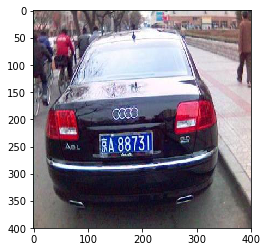

In [16]:
image_file = 'D:/jupyter/car-management/recognitionalgorithm/dataset/testim/京A88731.jpg'
im_data = np.array(Image.open(image_file))
single_X = im_data.reshape([1, 400, 400, 3])
plt.imshow(im_data)

In [18]:
single_y = build_model.predict(single_X)
y_predict_test = utils.getlistargmax(single_y)
y_predict_label_test = utils.getLabel(root, filename, np.absolute(y_predict_test))
print(y_predict_label_test)
print(y_predict_test)

京A88731
[9, 41, 39, 39, 38, 34, 32]
